# Importing Packages


In [1]:
# -----------------------------
# 1. Imports and Seed Setup
# -----------------------------

# Standard library
import os
import glob
import math
import re
import shutil
import time
import json
import warnings
from pathlib import Path

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

# PyTorch
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import autocast, GradScaler

# PyTorch Geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_geometric.nn import EdgeConv, knn_graph, global_max_pool


# PyTorch Ignite
from ignite.engine import Engine, Events
from ignite.metrics import Loss
from ignite.metrics.metric import Metric
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar
from ignite.contrib.handlers.tensorboard_logger import TensorboardLogger

# Warnings
warnings.filterwarnings("ignore")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
cudnn.deterministic = True
cudnn.benchmark = False


print(torch.__version__)     # e.g., 2.1.0
print(torch.version.cuda) 


2.3.0+cu121
12.1


C:\Windows\Temp\ipykernel_8212\3371436108.py:45: DeprecationWarning: d:\Temp_Work\Run_Pod_Files\.venv\lib\site-packages\ignite\contrib\handlers\tensorboard_logger.py has been moved to /ignite/handlers/tensorboard_logger.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  from ignite.contrib.handlers.tensorboard_logger import TensorboardLogger


In [2]:
# -----------------------------
# PyG Extension Sanity Check
# -----------------------------
try:
    import torch_scatter
    import torch_sparse
    import torch_cluster
    import torch_spline_conv
    from torch_geometric.nn import knn_graph

    # Create dummy inputs
    x = torch.randn(32, 3).cuda()  # 32 3D points
    batch = torch.zeros(32, dtype=torch.long).cuda()
    edge_index = knn_graph(x, k=4, batch=batch)

    print("✅ PyG extensions loaded and working.")
except ImportError as e:
    print("❌ PyG Import Error:", e)
except Exception as e:
    print("❌ PyG Runtime Error:", e)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


✅ PyG extensions loaded and working.


# EDA

In [3]:
file_path = Path("..") / "dataset" / "raw" / "DrivAerNetPlusPlus_Drag_8k_cleaned.csv"
df = pd.read_csv(file_path)
df.describe()

,Average Cd
count,7713.000000
mean,0.284412
std,0.037232
min,0.201138
25%,0.255859
50%,0.282987
75%,0.311521
max,0.383330


In [4]:
import torch

# Check if CUDA is available
print("CUDA Available:", torch.cuda.is_available())

# Get current device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Print GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Memory Allocated:", torch.cuda.memory_allocated(0) / 1024**2, "MB")
    print("Memory Cached:", torch.cuda.memory_reserved(0) / 1024**2, "MB")


CUDA Available: True
Using device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
Memory Allocated: 0.0029296875 MB
Memory Cached: 2.0 MB


<Axes: xlabel='Average Cd', ylabel='Count'>

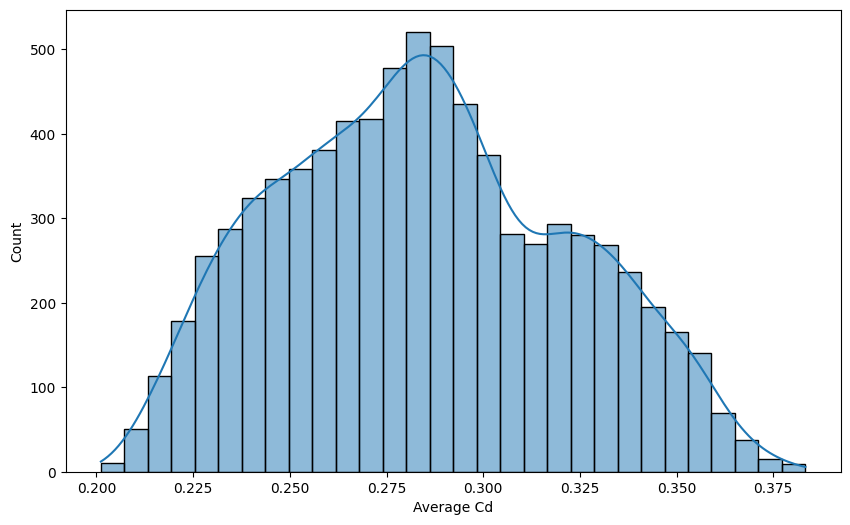

In [5]:
# Plot the pdf graph for Average Drag Coefficient (Cd)
plt.figure(figsize=(10, 6))
sns.histplot(df['Average Cd'], bins=30, kde=True)

# Pepraring Scaler Function and Global variables

In [6]:
# -----------------------------
# 1.2.1. Prepaing Scaler
# -----------------------------

# Base path
base_path = Path("..") / "dataset"

# Subset to only training car IDs
train_ids_path = base_path / "raw" / "subset_dir" / "train_design_ids.txt"
with open(train_ids_path) as f:
    train_ids = [line.strip() for line in f]

df_train = df[df["Design"].isin(train_ids)]

cd_scaler = StandardScaler()
cd_scaler.fit(df_train[["Average Cd"]])

print(f"Scaler mean: {cd_scaler.mean_[0]:.6f}, std: {cd_scaler.scale_[0]:.6f}")

# Save cd_scaler to disk
scaler_dir = base_path / "scaler"
scaler_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(cd_scaler, scaler_dir / "cd_scaler.pkl")

Scaler mean: 0.284506, std: 0.037448


['..\\dataset\\scaler\\cd_scaler.pkl']

In [7]:
# -----------------------------
# 1.2.2. Prepaing Point_Scaler
# -----------------------------
from pathlib import Path
import joblib
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np
import os

# Define paths
scaler_dir = Path("../dataset/scaler")
point_scaler_path = scaler_dir / "point_scaler.pkl"

# Check if the scaler file already exists
if point_scaler_path.exists():
    print(f"[INFO] Found existing point scaler. Loading from {point_scaler_path}")
    point_scaler = joblib.load(point_scaler_path)
else:
    print("[INFO] Point scaler not found. Generating a new one...")
    
    # --- Original generation script ---
    ids_txt = "../dataset/raw/subset_dir/train_design_ids.txt"
    raw_npy_dir = "../dataset/processed/slices"
    train_ids = [line.strip() for line in open(ids_txt)]

    print("Calculating stats for input point coordinates from the training set...")
    point_sample = []
    # Iterate through all training IDs to get a representative statistic
    for car_id in tqdm(train_ids, desc="Scanning raw slices"): 
        slices_path = os.path.join(raw_npy_dir, f"{car_id}_axis-x.npy")
        if os.path.exists(slices_path):
            slices = np.load(slices_path, allow_pickle=True)
            for s in slices:
                # Ensure the slice is not empty
                if s.shape[0] > 0:
                    point_sample.append(s)

    # Vertically stack all points from all slices into one large array
    all_points = np.vstack(point_sample)

    # Fit a scaler on the (x, y) coordinates of the points
    point_scaler = StandardScaler()
    point_scaler.fit(all_points)

    print("[INFO] New scaler generated. Saving to disk...")
    # Ensure the directory exists before saving
    scaler_dir.mkdir(parents=True, exist_ok=True)
    joblib.dump(point_scaler, point_scaler_path)
    print(f"[INFO] Scaler saved successfully to {point_scaler_path}")

# This will print the stats for either the loaded or newly generated scaler
print(f"\nPoint Scaler Ready:")
print(f"  Mean: {point_scaler.mean_}")
print(f"  Std:  {point_scaler.scale_}")

[INFO] Found existing point scaler. Loading from ..\dataset\scaler\point_scaler.pkl

Point Scaler Ready:
  Mean: [-0.00664036  0.52892731]
  Std:  [0.65939748 0.38759915]


# Model

In [8]:
# ###################################
# Minimal EdgeConv Slice Encoder (Replaces PointNet2D)
# ###################################
class EdgeConvSliceEncoder(nn.Module):
    """
    Encodes a batch of 2D slices, each with a variable number of points,
    into a fixed-size embedding vector for each slice.
    This module is designed to work with PyTorch Geometric's Batch object.
    """
    def __init__(self, input_dim=2, emb_dim=256, k=20):
        super().__init__()
        self.k = k

        # Define the MLP that will be used inside EdgeConv
        # It processes concatenated features of a point and its neighbors
        mlp = nn.Sequential(
            nn.Linear(2 * input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, emb_dim) # Output the final embedding dimension
        )

        # The EdgeConv layer itself
        self.edge_conv = EdgeConv(nn=mlp, aggr='max')

    def forward(self, data):
        """
        Processes a PyG Batch object representing multiple slices.
        Args:
            data (torch_geometric.data.Batch): A batch of slices, containing:
                - data.x (Tensor): All points from all slices concatenated [N_total_points, 2].
                - data.batch (Tensor): A tensor mapping each point to its original slice
                                    in the batch [N_total_points].
        Returns:
            Tensor: A tensor of shape [num_slices_in_batch, emb_dim].
        """
        # 1. Dynamically build the k-NN graph for the current set of points.
        #    `knn_graph` is batch-aware and will not connect points from different slices.
        edge_index = knn_graph(data.x, k=self.k, batch=data.batch)

        # 2. Apply the EdgeConv layer to learn features for each point.
        point_features = self.edge_conv(data.x, edge_index)

        # 3. Use global max pooling to get ONE fixed-size vector per slice.
        #    `global_max_pool` is also batch-aware.
        slice_embedding = global_max_pool(point_features, data.batch)

        return slice_embedding

In [9]:
# ################################
# Attention Pooling Transformer Encoder
# ################################
# --- Your helper function (define this once outside the class) ---
def generate_sinusoidal_position_embeddings(max_seq_len, embedding_dim):
    pe = torch.zeros(max_seq_len, embedding_dim)
    position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.unsqueeze(0) # Add batch dimension for (1, S, D)

# --- Your TransformerSliceEncoder class ---
class TransformerSliceEncoder(nn.Module):
    def __init__(
        self,
        input_dim: int = 256, 
        hidden_dim: int = 256,
        num_layers: int = 2,
        nhead: int = 1,
        dropout: float = 0.1,
        max_seq_len: int = 80, # Fixed at 80
    ):
        super().__init__()
        # KEY CHANGE 1: Use the pre-calculated sinusoidal embeddings
        # We register it as a buffer so it's moved to GPU with the model,
        # but NOT optimized by the optimizer (fixed).
        self.register_buffer(
            'pos_encoder',
            generate_sinusoidal_position_embeddings(max_seq_len, input_dim)
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=nhead,
            dim_feedforward=hidden_dim * 2,
            dropout=dropout,
            batch_first=True,
            activation="relu"
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.attn_pool = nn.Linear(input_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, src_key_padding_mask: torch.Tensor = None):
        """
        x: (B, S, D)
        src_key_padding_mask: (B, S) mask with True = pad, False = valid
        """
        B, S, D = x.shape
        # KEY CHANGE 2: No change here, the addition logic remains the same.
        # Now, self.pos_encoder contains fixed, meaningful position info.
        x = x + self.pos_encoder[:, :S, :]

        out = self.transformer(x, src_key_padding_mask=src_key_padding_mask)

        # Attention pooling
        scores = self.attn_pool(out).squeeze(-1)  # (B, S)
        
        if src_key_padding_mask is not None:
            scores = scores.masked_fill(src_key_padding_mask, -1e9)

        attn_weights = torch.softmax(scores, dim=-1)  # (B, S)
        pooled = torch.sum(attn_weights.unsqueeze(-1) * out, dim=1)  # (B, D)

        return self.dropout(pooled)


In [10]:
# ################################
# Regression Model for Cd
# ################################

class CdRegressor(nn.Module):
    def __init__(self, input_dim=256):  
        """
        A simple regression model to predict the average drag coefficient (Cd) from the output of the TransformerSliceEncoder.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(), 
            nn.Linear(128, 1)  # Output layer for regression
        )

    def forward(self, x):
        """
        x: (B, input_dim)
        returns: (B,)
        """
        return self.net(x).squeeze(1)


In [11]:
# PREDICTOR NET FOR EXPERIMENTING EDGE CONV
class CdPredictorNet(nn.Module):
    def __init__(self, slice_encoder, transformer_encoder, regressor):
        super().__init__()
        self.slice_encoder = slice_encoder
        self.transformer_encoder = transformer_encoder
        self.regressor = regressor

    def forward(self, car_slice_batches):
        """
        Args:
            car_slice_batches (list of torch_geometric.data.Batch):
                A list of length 80. Each element is a PyG Batch object
                representing all slices at that index from the main training batch.
        """
        device = next(self.parameters()).device
        slice_embeddings = []

        for slice_batch in car_slice_batches:
            slice_batch = slice_batch.to(device)
            embedding = self.slice_encoder(slice_batch)
            slice_embeddings.append(embedding)

        transformer_input = torch.stack(slice_embeddings, dim=0)
        transformer_input = transformer_input.transpose(0, 1)

        car_emb = self.transformer_encoder(transformer_input)

        return self.regressor(car_emb)

# Dataset loader and Model Summary

In [12]:
# ################################
# Dataset with Optional Size Control
# ################################
# In your CarSlicesDataset_PyG class
class CarSlicesDataset_PyG(torch.utils.data.Dataset):
    def __init__(self, ids_txt, raw_npy_dir, csv_path, cd_scaler=None, point_scaler=None, max_size=None):
        """
        Args:
            ids_txt (str): Path to the text file containing car IDs.
            raw_npy_dir (str): Directory containing the RAW .npy files (object arrays).
            csv_path (str): Path to the CSV file with Cd values.
            scaler (object, optional): Scaler for normalizing Cd values.
            max_size (int, optional): If specified, limits number of cars loaded.
        """
        all_ids = [line.strip() for line in open(ids_txt)]
        if max_size is not None:
            self.car_ids = all_ids[:max_size]
        else:
            self.car_ids = all_ids

        self.raw_npy_dir = raw_npy_dir
        self.cd_map = pd.read_csv(csv_path).set_index("Design")["Average Cd"].to_dict()
        self.cd_scaler = cd_scaler
        self.point_scaler = point_scaler # Add this
    
    def __len__(self):
        return len(self.car_ids)

    def __getitem__(self, idx):
        car_id = self.car_ids[idx]
        raw_slices = np.load(os.path.join(self.raw_npy_dir, f"{car_id}_axis-x.npy"), allow_pickle=True)
        cd_value = np.float32(self.cd_map[car_id])

        # Apply point scaler if available
        if self.point_scaler:
            processed_slices = [self.point_scaler.transform(s) for s in raw_slices if s.shape[0] > 0]
        else:
            processed_slices = [s for s in raw_slices if s.shape[0] > 0]

        slice_data_list = [
            Data(x=torch.from_numpy(s.astype(np.float32))) for s in processed_slices
        ]

        if self.cd_scaler:
            cd_value = self.cd_scaler.transform([[cd_value]])[0, 0]

        return slice_data_list, cd_value

# ################################
# Unchanged Collate Function
# ################################
def collate_fn_pyg(batch):
    car_data_list, cd_list = zip(*batch)
    slices_by_index = zip(*car_data_list)
    batched_slices = [Batch.from_data_list(slice_list) for slice_list in slices_by_index]
    cd_values = torch.tensor(cd_list, dtype=torch.float32)
    return batched_slices, cd_values


# Training Loop

In [13]:


# Custom RMSE metric
class RMSE(Metric):
    def reset(self):
        self._sum_squared_error = 0.0
        self._num_examples = 0

    def update(self, output):
        y_pred, y = output
        errors = (y_pred - y) ** 2
        self._sum_squared_error += torch.sum(errors).item()
        self._num_examples += y.shape[0]

    def compute(self):
        return (self._sum_squared_error / self._num_examples) ** 0.5

# Custom R² metric
class R2Score(Metric):
    def reset(self):
        self._y_true = []
        self._y_pred = []

    def update(self, output):
        y_pred, y = output
        self._y_pred.extend(y_pred.detach().cpu().numpy().flatten())
        self._y_true.extend(y.detach().cpu().numpy().flatten())

    def compute(self):
        return r2_score(self._y_true, self._y_pred)


# Create training engine ---
def create_trainer(model, optimizer, loss_fn, device, accumulation_steps):
    scaler = GradScaler()  # add the scaler

    def _update(engine, batch):
        model.train()
        car_slice_batches, cd_gt = batch
        cd_gt = cd_gt.to(device)

        if (engine.state.iteration - 1) % accumulation_steps == 0:
            optimizer.zero_grad()

        with autocast():
            pred = model(car_slice_batches)
            loss = loss_fn(pred, cd_gt.float()) / accumulation_steps

        # Use scaler for backward
        scaler.scale(loss).backward()

        if (engine.state.iteration % accumulation_steps) == 0:
            scaler.step(optimizer)
            scaler.update()

        return pred, cd_gt

    return Engine(_update)

# --- MODIFIED: Create evaluation engine ---
def create_evaluator(model, loss_fn, device):
    def _inference(engine, batch):
        model.eval()
        with torch.no_grad():
            # NEW: Unpack the simplified batch format
            car_slice_batches, cd_gt = batch
            cd_gt = cd_gt.to(device) # Move only the GT tensor to the device here
            with autocast():
                # NEW: Pass only the list of batches to the model
                pred = model(car_slice_batches)
        return pred, cd_gt

    return Engine(_inference)

# Attach metrics to an engine
def attach_metrics(engine, loss_fn):
    Loss(loss_fn).attach(engine, "loss")
    RMSE().attach(engine, "rmse")
    R2Score().attach(engine, "r2")


In [14]:
from torch.utils.tensorboard import SummaryWriter

def train_model(
    resume: bool = True,
    delete_previous_model_dir: bool = False,
    num_epochs: int = 50,
    batch_size: int = 1,
    learning_rate: float = 1e-4,
    accumulation_steps: int = 32,
    early_stopping_patience: int = 5,
    model_dir: str = "./model_dir",

    # Dataset configuration
    training_set_size: int = None,
    validation_set_size: int = None,
    train_ids_txt: str = "../dataset/raw/subset_dir/train_design_ids.txt",
    val_ids_txt: str = "../dataset/raw/subset_dir/val_design_ids.txt",
    raw_npy_dir: str = "../dataset/processed/slices",
    csv_path: str = "../dataset/raw/DrivAerNetPlusPlus_Drag_8k_cleaned.csv",
    cd_scaler=None,
    point_scaler=None, 

    # # Model hyperparameters (Hyperparameter for EdgeConv) ---
    k_neighbors: int = 25,
    slice_embedding_dim: int = 256,
    transformer_hidden_dim: int = 256,
    transformer_num_layers: int = 2,
    transformer_nhead: int = 1,
    cd_regressor_input_dim: int = 256,
):
    checkpoints_dir = os.path.join(model_dir, "checkpoints")
    results_dir = os.path.join(model_dir, "results")
    os.makedirs(checkpoints_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)

    # 1) Optional cleanup
    if delete_previous_model_dir and not resume:
        if os.path.isdir(model_dir) and os.listdir(model_dir):
            confirm = input(f"[WARN] Contents found in '{model_dir}'. Delete all contents? (yes/no): ").strip().lower()
            if confirm == "yes":
                # Delete all contents inside model_dir
                for entry in os.scandir(model_dir):
                    if entry.is_dir():
                        shutil.rmtree(entry.path)
                    else:
                        os.remove(entry.path)
                print(f"[INFO] All contents of '{model_dir}' have been deleted.")
            else:
                print("[INFO] Cleanup aborted by user.")
        else:
            print(f"[INFO] Nothing to clean. '{model_dir}' is empty or does not exist.")


    # 2) Model setup
    
    # --- MODIFIED: Model setup ---
    print(f"[INFO] Setting up model with k={k_neighbors} for EdgeConv...")
    slice_encoder = EdgeConvSliceEncoder(input_dim=2, emb_dim=slice_embedding_dim, k=k_neighbors)
    encoder = TransformerSliceEncoder(input_dim=slice_embedding_dim, hidden_dim=transformer_hidden_dim, num_layers=transformer_num_layers, nhead=transformer_nhead)
    regressor = CdRegressor(input_dim=cd_regressor_input_dim)
    model = CdPredictorNet(slice_encoder, encoder, regressor).to(device)


    print(model)
    print(f"[INFO] Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # 3) Training components
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    
    loss_fn = nn.SmoothL1Loss()
    trainer = create_trainer(model, optimizer, loss_fn, device, accumulation_steps)
    evaluator = create_evaluator(model, loss_fn, device)
    attach_metrics(trainer, loss_fn)
    attach_metrics(evaluator, loss_fn)

    train_pbar = ProgressBar(persist=True, desc="Training")
    train_pbar.attach(trainer, metric_names=["loss", "rmse", "r2"])
    val_pbar = ProgressBar(persist=True, desc="Validation")
    val_pbar.attach(evaluator, metric_names=["loss", "rmse", "r2"])

    # 4) Data setup ---
    print(f"[INFO] Loading data from raw npy directory: {raw_npy_dir}")
    train_dataset = CarSlicesDataset_PyG(train_ids_txt, raw_npy_dir, csv_path, cd_scaler, point_scaler, training_set_size)
    val_dataset = CarSlicesDataset_PyG(val_ids_txt, raw_npy_dir, csv_path, cd_scaler, point_scaler, validation_set_size)

    train_loader = PyGDataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn_pyg,
    )
    val_loader = PyGDataLoader(
        val_dataset,
        batch_size=batch_size * 2,
        shuffle=False,
        collate_fn=collate_fn_pyg,
    )

    # 5) Resume
    start_epoch = 1
    if resume:
        ckpts = sorted(glob.glob(os.path.join(checkpoints_dir, "epoch_*.pt")))
        if ckpts:
            last_ckpt = ckpts[-1]
            print(f"[INFO] Resuming from checkpoint: {os.path.basename(last_ckpt)}")
            data = torch.load(last_ckpt, map_location=device)
            model.load_state_dict(data["model"])
            optimizer.load_state_dict(data["optimizer"])
            start_epoch = data.get("epoch", 1) + 1
        else:
            print("[INFO] No checkpoint found. Starting fresh.")

    # 6) TensorBoard
    tb_writer = SummaryWriter(log_dir=os.path.join(checkpoints_dir, "logs"), purge_step=start_epoch - 1)

    # 7) Best model saving
    evaluator.add_event_handler(Events.COMPLETED, ModelCheckpoint(
        dirname=checkpoints_dir,
        filename_prefix="best_model",
        n_saved=1,
        score_function=lambda eng: eng.state.metrics["r2"],
        score_name="r2",
        global_step_transform=lambda eng, _: eng.state.epoch + start_epoch - 1,
        require_empty=False
    ), {"model": model})

    # 8) Early stopping
    evaluator.add_event_handler(Events.COMPLETED, EarlyStopping(
        patience=early_stopping_patience,
        score_function=lambda eng: eng.state.metrics["r2"],
        trainer=trainer
    ))

    # 9) Load previous history if exists
    history_path = os.path.join(results_dir, "training_history.json")
    new_history = []
    if os.path.exists(history_path):
        with open(history_path, "r") as f:
            new_history = json.load(f)
    else:
        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname(history_path), exist_ok=True)

    # 10) Validation handler
    @trainer.on(Events.EPOCH_COMPLETED)
    def validate(engine):
        evaluator.run(val_loader)
        epoch_num = engine.state.epoch + start_epoch - 1
        train_metrics = engine.state.metrics
        val_metrics = evaluator.state.metrics
    
    # 11) Record and log metrics and save history 
        record = {
            "epoch": epoch_num,
            "Train_loss": train_metrics["loss"],
            "Train_rmse": train_metrics["rmse"],
            "Train_r2": train_metrics["r2"],
            "Val_loss": val_metrics["loss"],
            "Val_rmse": val_metrics["rmse"],
            "Val_r2": val_metrics["r2"],
        }
        new_history.append(record)

        tb_writer.add_scalars("Loss", {
            "Train": train_metrics["loss"],
            "Validation": val_metrics["loss"]
        }, epoch_num)
        tb_writer.add_scalars("RMSE", {
            "Train": train_metrics["rmse"],
            "Validation": val_metrics["rmse"]
        }, epoch_num)
        tb_writer.add_scalars("R2", {
            "Train": train_metrics["r2"],
            "Validation": val_metrics["r2"]
        }, epoch_num)

        print(f"\n[Epoch {epoch_num:03d}] ------------------------")
        for key, value in record.items():
            if key != "epoch":
                print(f"{key:17}: {value:.6f}" if isinstance(value, float) else f"{key:17}: {value}")

        with open(history_path + ".bak", "w") as f:
            json.dump(new_history, f, indent=2)
        with open(history_path, "w") as f:
            json.dump(new_history, f, indent=2)

        torch.save({
            "epoch": epoch_num,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict()
        }, os.path.join(checkpoints_dir, f"epoch_{epoch_num:03d}_loss_{val_metrics['loss']:.8f}.pt"))

    # 11) Run training
    try:
        trainer.run(train_loader, max_epochs=num_epochs - start_epoch + 1)
    except KeyboardInterrupt:
        print("\n⛔ Training interrupted by user.")
    finally:
        tb_writer.close()
        best_ckpt = sorted(glob.glob(os.path.join(checkpoints_dir, "best_model_*.pt")))
        if best_ckpt:
            print(f"[INFO] Loading best model from: {os.path.basename(best_ckpt[-1])}")
            best_model_data = torch.load(best_ckpt[-1], map_location=device)
            model.load_state_dict(best_model_data["model"] if "model" in best_model_data else best_model_data)

        with open(history_path, "r") as f:
            final_history = json.load(f)
        return model, final_history


# Training Model

In [15]:
# Directories
model_dir = "../model_outputs/DTM256_Model"
checkpoints_dir = os.path.join(model_dir, "checkpoints")
results_dir = os.path.join(model_dir, "results")
os.makedirs(checkpoints_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# History file paths
json_history_path = os.path.join(results_dir, "training_history.json")

# Call the training function
model, _ = train_model(
    # General training configuration
    resume=False,
    delete_previous_model_dir=True,
    num_epochs=100,
    batch_size=4,
    learning_rate=1e-5,
    accumulation_steps=4,
    early_stopping_patience= 10,
    model_dir = model_dir,

    # Dataset configuration
    training_set_size = 200,
    validation_set_size = 40,
    train_ids_txt="../dataset/raw/subset_dir/train_design_ids.txt",
    val_ids_txt="../dataset/raw/subset_dir/val_design_ids.txt",
    raw_npy_dir = "../dataset/processed/slices",
    csv_path  = "../dataset/raw/DrivAerNetPlusPlus_Drag_8k_cleaned.csv",
    cd_scaler=cd_scaler,
    point_scaler=point_scaler, 

    # --- MODIFIED: Model hyperparameters ---
    k_neighbors=16, 
    slice_embedding_dim = 512,
    transformer_hidden_dim = 512,
    transformer_num_layers = 4,
    transformer_nhead = 4, # A good starting point
    cd_regressor_input_dim= 512,
)

# Load Json history and convert to DataFrame and print
history_df = pd.read_json(json_history_path)
print(history_df.head())

[INFO] All contents of '../model_outputs/DTM256_Model' have been deleted.
[INFO] Setting up model with k=16 for EdgeConv...
CdPredictorNet(
  (slice_encoder): EdgeConvSliceEncoder(
    (edge_conv): EdgeConv(nn=Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=512, bias=True)
    ))
  )
  (transformer_encoder): TransformerSliceEncoder(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=512, bias=True)
          (norm1): Layer

Training [1/100]: [50/50] 100%|██████████ [01:02<00:00]
Validation: [5/5] 100%|██████████ [00:06<00:00]



[Epoch 001] ------------------------
Train_loss       : 0.338851
Train_rmse       : 0.849382
Train_r2         : -1.176519
Val_loss         : 0.246254
Val_rmse         : 0.713952
Val_r2           : -0.231510


Training [2/100]: [50/50] 100%|██████████, loss=0.339, rmse=0.849, r2=-1.18 [01:02<00:00]
Validation: [5/5] 100%|██████████, loss=0.246, rmse=0.714, r2=-0.232 [00:06<00:00]



[Epoch 002] ------------------------
Train_loss       : 0.209280
Train_rmse       : 0.653183
Train_r2         : -0.287138
Val_loss         : 0.205649
Val_rmse         : 0.644224
Val_r2           : -0.002707


Training [3/100]: [50/50] 100%|██████████, loss=0.209, rmse=0.653, r2=-0.287 [01:03<00:00]
Validation: [5/5] 100%|██████████, loss=0.206, rmse=0.644, r2=-0.00271 [00:06<00:00]



[Epoch 003] ------------------------
Train_loss       : 0.169780
Train_rmse       : 0.585195
Train_r2         : -0.033134
Val_loss         : 0.210552
Val_rmse         : 0.651992
Val_r2           : -0.027035


Training [4/100]: [50/50] 100%|██████████, loss=0.17, rmse=0.585, r2=-0.0331 [01:03<00:00]
Validation: [5/5] 100%|██████████, loss=0.211, rmse=0.652, r2=-0.027 [00:06<00:00]



[Epoch 004] ------------------------
Train_loss       : 0.164790
Train_rmse       : 0.577234
Train_r2         : -0.005217
Val_loss         : 0.220380
Val_rmse         : 0.668546
Val_r2           : -0.079849


Training [5/100]: [50/50] 100%|██████████, loss=0.165, rmse=0.577, r2=-0.00522 [01:03<00:00]
Validation: [5/5] 100%|██████████, loss=0.22, rmse=0.669, r2=-0.0798 [00:06<00:00]



[Epoch 005] ------------------------
Train_loss       : 0.165653
Train_rmse       : 0.579109
Train_r2         : -0.011757
Val_loss         : 0.217779
Val_rmse         : 0.664140
Val_r2           : -0.065661


Training [6/100]: [50/50] 100%|██████████, loss=0.166, rmse=0.579, r2=-0.0118 [01:03<00:00]
Validation: [5/5] 100%|██████████, loss=0.218, rmse=0.664, r2=-0.0657 [00:06<00:00]



[Epoch 006] ------------------------
Train_loss       : 0.164339
Train_rmse       : 0.576434
Train_r2         : -0.002433
Val_loss         : 0.211875
Val_rmse         : 0.654203
Val_r2           : -0.034012


Training [7/100]: [50/50] 100%|██████████, loss=0.164, rmse=0.576, r2=-0.00243 [01:03<00:00]
Validation: [5/5] 100%|██████████, loss=0.212, rmse=0.654, r2=-0.034 [00:06<00:00]



[Epoch 007] ------------------------
Train_loss       : 0.163586
Train_rmse       : 0.574891
Train_r2         : 0.002928
Val_loss         : 0.212968
Val_rmse         : 0.656036
Val_r2           : -0.039813


Training [8/100]: [50/50] 100%|██████████, loss=0.164, rmse=0.575, r2=0.00293 [01:02<00:00]
Validation: [5/5] 100%|██████████, loss=0.213, rmse=0.656, r2=-0.0398 [00:06<00:00]



[Epoch 008] ------------------------
Train_loss       : 0.165637
Train_rmse       : 0.578539
Train_r2         : -0.009766
Val_loss         : 0.211217
Val_rmse         : 0.653107
Val_r2           : -0.030548


Training [9/100]: [50/50] 100%|██████████, loss=0.166, rmse=0.579, r2=-0.00977 [01:02<00:00]
Validation: [5/5] 100%|██████████, loss=0.211, rmse=0.653, r2=-0.0305 [00:06<00:00]



[Epoch 009] ------------------------
Train_loss       : 0.163033
Train_rmse       : 0.574039
Train_r2         : 0.005879
Val_loss         : 0.212790
Val_rmse         : 0.655740
Val_r2           : -0.038876


Training [10/100]: [50/50] 100%|██████████, loss=0.163, rmse=0.574, r2=0.00588 [01:03<00:00]
Validation: [5/5] 100%|██████████, loss=0.213, rmse=0.656, r2=-0.0389 [00:06<00:00]



[Epoch 010] ------------------------
Train_loss       : 0.163834
Train_rmse       : 0.575271
Train_r2         : 0.001608
Val_loss         : 0.215264
Val_rmse         : 0.659896
Val_r2           : -0.052086


Training [11/100]: [50/50] 100%|██████████, loss=0.164, rmse=0.575, r2=0.00161 [01:02<00:00]
Validation: [5/5] 100%|██████████, loss=0.215, rmse=0.66, r2=-0.0521 [00:06<00:00]



[Epoch 011] ------------------------
Train_loss       : 0.165190
Train_rmse       : 0.578180
Train_r2         : -0.008513
Val_loss         : 0.213649
Val_rmse         : 0.657179
Val_r2           : -0.043441


Training [12/100]: [50/50] 100%|██████████, loss=0.165, rmse=0.578, r2=-0.00851 [01:03<00:00]
Validation: [5/5] 100%|██████████, loss=0.214, rmse=0.657, r2=-0.0434 [00:06<00:00]
2025-07-09 12:36:36,030 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training



[Epoch 012] ------------------------
Train_loss       : 0.165699
Train_rmse       : 0.578690
Train_r2         : -0.010294
Val_loss         : 0.212938
Val_rmse         : 0.655989
Val_r2           : -0.039664
[INFO] Loading best model from: best_model_model_1_r2=-0.0027.pt
   epoch  Train_loss  Train_rmse  Train_r2  Val_loss  Val_rmse    Val_r2
0      1    0.338851    0.849382 -1.176519  0.246254  0.713952 -0.231510
1      2    0.209280    0.653183 -0.287138  0.205649  0.644224 -0.002707
2      3    0.169780    0.585195 -0.033134  0.210552  0.651992 -0.027035
3      4    0.164790    0.577234 -0.005217  0.220380  0.668546 -0.079849
4      5    0.165653    0.579109 -0.011757  0.217779  0.664140 -0.065661


# Evaluation